<a href="https://colab.research.google.com/github/decembersnow1234/SDA-millenials/blob/main/DeepLearningversion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:


# Import additional libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge



# Préparation des Données


## Charger et explorer le dataset GTSRB.


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


# Importation des bibliothèques

In [10]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import tensorflow as tf
!pip install --quiet openml

In [11]:
%matplotlib inline
import openml as oml
import matplotlib.pyplot as plt

In [12]:
import os

# List files in the dataset directory
dataset_files = os.listdir(path)
print("Files in dataset directory:", dataset_files)



Files in dataset directory: ['Test.csv', 'Meta', 'train', 'test', 'Meta.csv', 'meta', 'Test', 'Train.csv', 'Train']


In [13]:
import pandas as pd

# Load CSV files
train_df = pd.read_csv(os.path.join(path, 'Train.csv'))
test_df = pd.read_csv(os.path.join(path, 'Test.csv'))
meta_df = pd.read_csv(os.path.join(path, 'Meta.csv'))
# Check dataset structure
print(train_df.head())


   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [14]:
test_df.ClassiId.distinct()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [15]:
meta_df.describe()

,ClassId,ShapeId,ColorId
count,43.000000,43.000000,43.000000
mean,21.000000,0.790698,0.511628
std,12.556539,0.803508,0.935340
min,0.000000,0.000000,0.000000
25%,10.500000,0.000000,0.000000
50%,21.000000,1.000000,0.000000
75%,31.500000,1.000000,1.000000
max,42.000000,4.000000,3.000000


## Prétraitement des images : redimensionnement, normalisation.



In [17]:
import os

# Define dataset path
dataset_path = "/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1"

# Fix paths: Remove extra "Train/" and ensure they point to the correct "train" folder
train_df['Path'] = train_df['Path'].apply(lambda x: os.path.join(dataset_path, "train", x.replace("Train/", "")))


from PIL import Image

# Pick a sample image
sample_img_path = train_df.iloc[0]['Path']
print("Fixed sample image path:", sample_img_path)

# Check if it exists
if os.path.exists(sample_img_path):
    img = Image.open(sample_img_path)
    img.show()  # Opens the image
else:
    print("File does not exist:", sample_img_path)


# Load a sample image
sample_img_path = train_df.iloc[0]['Path']
img = Image.open(sample_img_path)

# Print image size
print("Original Image Size:", img.size)


import matplotlib.pyplot as plt

def show_sample_images(df):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img_path = df.iloc[i]['Path']
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Class: {df.iloc[i]['ClassId']}")
        ax.axis('off')
    plt.show()

# Show images
show_sample_images(train_df)



Fixed sample image path: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/train/20/00020_00000_00000.png


Original Image Size: (27, 26)


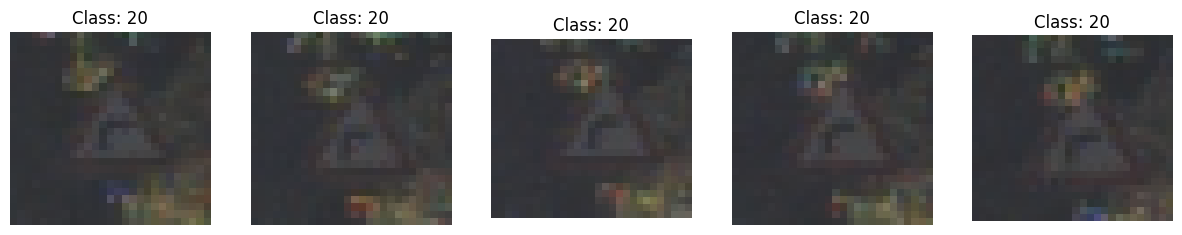

## Diviser le dataset en ensembles d’entraînement, de validation et de test.


## Augmentation des données : Appliquer des techniques comme la rotation, le zoom, la translation, et les variations de luminosité pour augmenter artificiellement la taille du dataset et améliorer la robustesse du modèle.


In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from PIL import Image

# Define image size
IMG_SIZE = (32, 32)

# Load images and labels
X, y = [], []

for _, row in train_df.iterrows():
    img_path = row['Path']
    label = row['ClassId']

    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB')  # Ensure 3 channels (RGB)
        img = img.resize(IMG_SIZE)  # Resize
        X.append(np.array(img))  # Convert to NumPy array
        y.append(label)

X = np.array(X)   # Normalize pixel values
y = np.array(y)
y = to_categorical(y, num_classes=len(set(y)))  # One-hot encode labels

print("Dataset shape:", X.shape, y.shape)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Randomly rotate images by 20 degrees
    width_shift_range=0.2,   # Shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Shift images vertically by 20% of the height
    shear_range=0.2,         # Shear images by 20%
    zoom_range=0.2,          # Randomly zoom images by 20%
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill in missing pixels after transformations
)



from sklearn.model_selection import train_test_split

# First split into training+validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
# Fit the data augmentation on training images
datagen.fit(X_train, y_train)  # Assuming X contains the training data

# Then split training+validation into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Print the shapes
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_test.shape, y_test.shape)
#print("Test set:", X_test.shape, y_test.shape)


Dataset shape: (39209, 32, 32, 3) (39209, 43)


TypeError: ImageDataGenerator.fit() got an unexpected keyword argument 'batch_size'

In [ ]:

y.shape[1]

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense
from keras.regularizers import l2
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, lr):
    return lr * 0.9 if epoch > 5 else lr



lr_callback = LearningRateScheduler(lr_schedule)

#import mlflow
#mlflow.set_tracking_uri("https://2403-34-87-132-72.ngrok-free.app:5000")

#with mlflow.start_run(run_name="model_run_name"):
#    mlflow.log_param("alpha", 0.95)
#    mlflow.log_param("param_name", "value")

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)




    # Define CNN Model with Batch Normalization
def create_model():
  model = Sequential([
      Conv2D(32, (5,5), activation='relu', padding="same",  input_shape=(32, 32, 3)),
      BatchNormalization(),  # Added Batch Normalization
      Dropout(0.1),
      MaxPooling2D(2,2),

      Conv2D(64, (3,3), activation='relu', padding="same"),
      BatchNormalization(),
      Dropout(0.2),
      MaxPooling2D(2,2),

      Conv2D(128, (3,3), activation='relu', padding="same"),
      BatchNormalization(),
      Dropout(0.2),
      MaxPooling2D(2,2),

      Flatten(),
      Dense(64, activation='relu'),
      BatchNormalization(),
      Dropout(0.4),
      Dense(y.shape[1], activation='softmax')  # Output layer with num_classes
  ])

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model  # Indentation fixed here


    # Train the Model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[early_stopping, lr_callback]
)
# Log training metrics per epoch
#for epoch in range(len(history.history['loss'])):
#      mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
#      mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
#      mlflow.log_metric("train_acc", history.history['accuracy'][epoch], step=epoch)
#      mlflow.log_metric("val_acc", history.history['val_accuracy'][epoch], step=epoch)

    # Save & log the trained model
#model.save("traffic_sign_model.h5")
#mlflow.log_artifact("traffic_sign_model.h5")
model.summary()  # Print model structure



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 160s 163ms/step - accuracy: 0.5437 - loss: 1.5142 - val_accuracy: 0.7277 - val_loss: 0.8607 - learning_rate: 1.0000e-04
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 155s 158ms/step - accuracy: 0.5882 - loss: 1.3630 - val_accuracy: 0.7649 - val_loss: 0.7566 - learning_rate: 1.0000e-04
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 152s 155ms/step - accuracy: 0.6297 - loss: 1.2271 - val_accuracy: 0.7790 - val_loss: 0.6700 - learning_rate: 1.0000e-04
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 203s 156ms/step - accuracy: 0.6585 - loss: 1.1178 - val_accuracy: 0.7984 - val_loss: 0.6022 - learning_rate: 1.0000e-04
Epoch 5/20
513/981 ━━━━━━━━━━━━━━━━━━━━ 1:12 155ms/step - accuracy: 0.6888 - loss: 1.0096

KeyboardInterrupt: 

import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical


# Create a KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

# Define StratifiedKFold for cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
results = cross_val_score(model, X, y, cv=kfold)

# Print results
print(f"Cross-Validation Accuracy: {results.mean()} ± {results.std()}")


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Ensure y is categorical (one-hot encoding)
y = to_categorical(y) if len(y.shape) == 1 else y  # Only convert if not already categorical

# Define a function to create the model
def create_model():
    model = Sequential([
        Conv2D(32, (5,5), activation='relu', padding="same", input_shape=(32, 32, 3)),
        BatchNormalization(),
        Dropout(0.1),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding="same"),
        BatchNormalization(),
        Dropout(0.2),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding="same"),
        BatchNormalization(),
        Dropout(0.2),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(y.shape[1], activation='softmax')  # Output layer with num_classes
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Convert y back to 1D for StratifiedKFold (for cross-validation compatibility)
y_labels = np.argmax(y, axis=1)

# Define StratifiedKFold for cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kfold.split(X, y_labels)):
    print(f"Training on fold {fold + 1}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model()
    # Include validation data in the fit method
    model.fit(datagen.flow(X_train, y_train), epochs=20, batch_size=32, verbose=1, validation_data=(X_val, y_val))

    # Evaluate the model
    scores = model.evaluate(X_val, y_val, verbose=0)
    cv_scores.append(scores[1] * 100)  # Append accuracy

# Print results
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Training on fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 167s 164ms/step - accuracy: 0.0769 - loss: 3.9340 - val_accuracy: 0.3303 - val_loss: 2.5342
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 156s 159ms/step - accuracy: 0.2395 - loss: 2.8902 - val_accuracy: 0.4380 - val_loss: 1.9967
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 160s 164ms/step - accuracy: 0.3229 - loss: 2.4608 - val_accuracy: 0.5398 - val_loss: 1.6492
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 160s 163ms/step - accuracy: 0.3941 - loss: 2.1324 - val_accuracy: 0.6038 - val_loss: 1.3488
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 204s 165ms/step - accuracy: 0.4594 - loss: 1.8654 - val_accuracy: 0.6510 - val_loss: 1.1527
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 161s 164ms/step - accuracy: 0.5139 - loss: 1.6505 - val_accuracy: 0.7186 - val_loss: 0.9472
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 154s 156ms/step - accuracy: 0.5587 - loss: 1.4778 - val_accuracy: 0.7604 - val_loss: 0.7916
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 164s 168ms/step - accuracy: 0.5980 -

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense
from keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, lr):
    return lr * 0.9 if epoch > 5 else lr

   

lr_callback = LearningRateScheduler(lr_schedule)



# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)




    # Define CNN Model with Batch Normalization
def create_model():
  model = Sequential([
      Conv2D(32, (5,5), activation='relu', padding="same",  input_shape=(32, 32, 3)),
      BatchNormalization(),  # Added Batch Normalization
      Dropout(0.1),
      MaxPooling2D(2,2),

      Conv2D(64, (3,3), activation='relu', padding="same"),
      BatchNormalization(),
      Dropout(0.2),
      MaxPooling2D(2,2),

      Conv2D(128, (3,3), activation='relu', padding="same"),
      BatchNormalization(),
      Dropout(0.2),
      MaxPooling2D(2,2),

      Flatten(),
      Dense(64, activation='relu'),
      BatchNormalization(),
      Dropout(0.4),
      Dense(y.shape[1], activation='softmax')  # Output layer with num_classes
  ])

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model  # Indentation fixed here

      
    # Train the Model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[early_stopping, lr_callback]
)


    # Save & log the trained model
#model.save("traffic_sign_model.h5")
#mlflow.log_artifact("traffic_sign_model.h5")
model.summary()  # Print model structure



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

def plot_gtsrb_training(history):
    """
    Plots the training history of a CNN model for the GTSRB dataset.

    Args:
        history: Keras History object from model.fit().
    """
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(10, 6))

    # Plot Train and Validation Accuracy
    plt.plot(epochs, history.history['accuracy'], label="Train Accuracy", lw=2)
    plt.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", lw=2)

    # Plot Train and Validation Loss
    plt.plot(epochs, history.history['loss'], label="Train Loss", lw=2, linestyle="--")
    plt.plot(epochs, history.history['val_loss'], label="Validation Loss", lw=2, linestyle="--")

    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Model Training History")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()  # Adjust layout for better visibility
    #display(plt.gcf())  # Force display of the plots

# Example usage with a Keras History object
# Assuming `history` is the History object returned by `model.fit()`
# history = model.fit(...)

plot_gtsrb_training(history)
